In [2]:
# canonical import statements
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [3]:
# images (for the discriminator)
X = tf.placeholder(tf.float32, shape=[None, 784])
# noise vector (for the generator)
Z = tf.placeholder(tf.float32, shape=[None, 100])


In [4]:
def xavier(shape):
    # idk if this will actually help but i read it in a paper
    return tf.truncated_normal(shape = shape, stddev = 1.0/tf.sqrt(shape[0]/2.0)) #"xavier" initialization of weights

class discriminator_network:
    """MNIST IMAGE(s): x * 784 -> 128 hidden units -> 1 output neuron (probability of being real)"""
    def __init__(self):
        self.d_w1 = tf.Variable(xavier([784,128]))
        self.d_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.d_w2 = tf.Variable(xavier([128,1]))
        self.d_b2 = tf.Variable(tf.zeros(shape=[1]))
    
    def discriminator(self, x):
        d_hfc_1 = tf.nn.relu(tf.matmul(x, self.d_w1) + self.d_b1)
        d_logit = tf.matmul(d_hfc_1, self.d_w2) + self.d_b2
        d_prob = tf.nn.sigmoid(d_logit)
        return d_prob, d_logit
    
    def get_trainable_vars(self):
        return self.d_w1, self.d_b1, self.d_w2, self.d_b2

class generator_network:
    """Random noise vector (100 dim assumed) -> expand to 128 units -> output 784 units (MNIST dim)"""
    def __init__(self):
        self.g_w1 = tf.Variable(xavier([100, 128])) # 100d noise vector assumed. Output 128 hidden units in first layer
        self.g_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.g_w2 = tf.Variable(xavier([128, 784])) # 784 outputs
        self.g_b2 = tf.Variable(tf.zeros(shape=[784]))
    
    def generator(self, z):
        g_hfc_1 = tf.nn.relu(tf.matmul(z, self.g_w1) + self.g_b1)
        return tf.nn.sigmoid(tf.matmul(g_hfc_1, self.g_w2) + self.g_b2)
    
    def get_trainable_vars(self):
        return self.g_w1, self.g_b1, self.g_w2, self.g_b2

In [5]:
# next, we need a function to actually generate a 100d noise vector to feed into our generator
def rand_noise_vector(num_vectors, size):
    return np.random.uniform(-1.0, 1.0, size = [num_vectors, size]) # we might want a bunch of these to generate many imgs


In [6]:
# a function to plot the genned images
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        plt.show()
        # TODO - write out to file

    return fig

In [10]:
# create networks
gen_net, discriminator_net = generator_network(), discriminator_network()
# forward the noise vector through the generator to get a generator image
g_sample = gen_net.generator(z=Z)
# output function for real images, output function for generated image
d_prob_real, d_logit_real = discriminator_net.discriminator(X)
d_prob_fake, d_logit_fake = discriminator_net.discriminator(g_sample)

# compute the loss with respect to the real logits
d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels = tf.ones_like(d_logit_real)))
# compute the loss, separately, with respect to the fake logits
d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.zeros_like(d_logit_fake)))
# total loss is just the sum
d_loss = d_real_loss + d_fake_loss

# train the generator w/fake logits
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.ones_like(d_logit_fake)))

# make sure to only train w/relevant vars
d_step = tf.train.AdamOptimizer().minimize(d_loss, var_list = discriminator_net.get_trainable_vars())
g_step = tf.train.AdamOptimizer().minimize(g_loss, var_list = gen_net.get_trainable_vars())

In [11]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


Epoch: 0
Discriminator loss: 1.441483736038208
Generator loss: 1.6949948072433472
Epoch: 1000
Discriminator loss: 0.08102024346590042
Generator loss: 4.536694526672363
Epoch: 2000
Discriminator loss: 0.43475741147994995
Generator loss: 3.587798595428467
Epoch: 3000
Discriminator loss: 0.8962908983230591
Generator loss: 2.1255552768707275
Epoch: 4000
Discriminator loss: 1.2880535125732422
Generator loss: 1.8795353174209595
Epoch: 5000
Discriminator loss: 1.2178404331207275
Generator loss: 1.3007352352142334
Epoch: 6000
Discriminator loss: 1.3386965990066528
Generator loss: 0.8442540168762207
Epoch: 7000
Discriminator loss: 1.3649057149887085
Generator loss: 1.1061701774597168
Epoch: 8000
Discriminator loss: 1.2713162899017334
Generator loss: 0.9247305393218994
Epoch: 9000
Discriminator loss: 1.2523308992385864
Generator loss: 1.0040396451950073
Epoch: 10000
Discriminator loss: 1.1401896476745605
Generator loss: 1.0451468229293823
Epoch: 11000
Discriminator loss: 1.2850284576416016
Gener

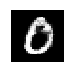

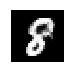

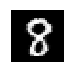

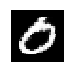

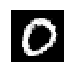

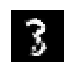

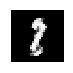

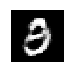

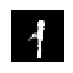

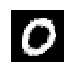

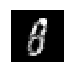

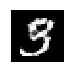

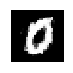

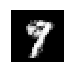

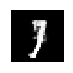

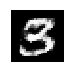

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = 0
    for epoch in range(100000): # increase this for more accuracy, but it will be more likely to collapse
        X_mb, _ = mnist.train.next_batch(128)
        _, cur_loss_d = sess.run([d_step, d_loss], feed_dict = {X: X_mb, Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        if epoch % 1000 == 0:
            print("Epoch: {}".format(epoch))
            print("Discriminator loss: {}".format(cur_loss_d))
            print("Generator loss: {}".format(cur_loss_g))
    %matplotlib inline
    samples = sess.run(g_sample, feed_dict={Z: rand_noise_vector(16, 100)})
    plot(samples) # 16 of em
        



### 